In [1]:
import fio.database
import mip

db = fio.database.load_db("data/base.json")

print(db.keys())

dict_keys(['assemblers', 'items', 'miners', 'modules', 'recipes', 'resources', 'versions'])


In [2]:
import functools

@functools.lru_cache(64)
def get_assembly_machines(category, craftable_only=True):
  ms = []

  for m in db.assemblers.find(f""".[] | select(.crafting_categories | contains(["{category}"]))"""):
    ms.append(m)

  return ms

recipes = fio.database.HyperDiGraph()

ignore_machines = ["steel-furnace", "stone-furnace"]

for r in db.recipes.find(".[]"):
    for m in get_assembly_machines(r['category']):

        if m["name"] in ignore_machines:
            continue

        A = {i["name"] for i in r["ingredients"]}
        B = {p["name"] for p in r["products"]}
        recipes.add_edge(A, B, {"recipe": r, "machine": m, "name": f"{r['name']}#{m['name']}"})


In [3]:
import json
from collections import defaultdict

# Load a sample JSON file
with open('data/base.json', 'r') as json_file:
    data = json.load(json_file)



# Analyze the JSON data
def analyze_json(json_data, output=None, parent_key=[]):
    if output is None:
        output = defaultdict(set)
    if isinstance(json_data, dict):
        for key, value in json_data.items():
            new_key = parent_key + [key]
            analyze_json(value, output, parent_key=new_key)
    elif isinstance(json_data, list):
        for item in json_data:
            analyze_json(item, output, parent_key=parent_key)
    else:
        output[tuple(parent_key)].add(type(json_data))
    
    return output

# Call the analyze_json function on the JSON data
analyze_json(data)

defaultdict(set,
            {('assemblers', 'allowed_effects', 'consumption'): {bool},
             ('assemblers', 'allowed_effects', 'pollution'): {bool},
             ('assemblers', 'allowed_effects', 'productivity'): {bool},
             ('assemblers', 'allowed_effects', 'speed'): {bool},
             ('assemblers', 'crafting_categories'): {str},
             ('assemblers', 'crafting_speed'): {float, int},
             ('assemblers', 'ingredient_count'): {int},
             ('assemblers', 'module_inventory_size'): {int},
             ('assemblers', 'name'): {str},
             ('items', 'name'): {str},
             ('items', 'stack_size'): {int},
             ('items', 'type'): {str},
             ('miners', 'allowed_effects', 'consumption'): {bool},
             ('miners', 'allowed_effects', 'pollution'): {bool},
             ('miners', 'allowed_effects', 'productivity'): {bool},
             ('miners', 'allowed_effects', 'speed'): {bool},
             ('miners', 'mining_speed'): 

In [4]:
import fio.flow


source = dict(**{resource: float("+inf") for resource in db.resources.query("map(.products[].name) | unique")})

source["water"] = float("+inf")

target = {
    k: 1 for k in {
        # 'basic-tech-card',
        # 'advanced-tech-card',
        # 'automation-science-pack',
        # 'biters-research-data',
        # 'chemical-science-pack',
        # 'logistic-science-pack',
        # 'production-science-pack',
        # 'utility-science-pack',
        # 'matter-research-data',
        # 'matter-tech-card',
        # 'military-science-pack',
        # 'singularity-tech-card',
        # "logistic-science-pack"
        # "advanced-logistic-science-pack",
        # "alien-science-pack",
        # "alien-science-pack-blue",
        # "alien-science-pack-green",
        # "alien-science-pack-orange",
        # "alien-science-pack-purple",
        # "alien-science-pack-red",
        # "alien-science-pack-yellow",
        "automation-science-pack",
        "chemical-science-pack",
        "logistic-science-pack",
        "military-science-pack",
        # "production-science-pack",
        # "science-pack-gold",
        # "space-science-pack",
        # "steam-science-pack",
        "utility-science-pack",

    }
}

print(source)

model = fio.flow.optimize_model(recipes, dict(**source, **{k: -v for k, v in target.items()}))

print(model["status"])
# model = build_detailed_graph(model)

{'coal': inf, 'copper-ore': inf, 'crude-oil': inf, 'iron-ore': inf, 'stone': inf, 'uranium-ore': inf, 'water': inf}
Welcome to the CBC MILP Solver 
Version: Trunk
Build Date: Jan 16 2024
Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 23 (-757) rows, 57 (-1079) columns and 147 (-3050) elements
Clp1000I sum of infeasibilities 8.01938e-05 - average 3.48669e-06, 7 fixed columns
Coin0506I Presolve 23 (0) rows, 50 (-7) columns and 131 (-16) elements
Clp0029I End of values pass after 49 iterations
Clp0014I Perturbing problem by 0.001% of 7.1177048 - largest nonzero change 0 ( 0%) - largest zero change 2.2273756e-05
Clp0000I Optimal - objective value 746.60303
Clp0000I Optimal - objective value 746.60303
Coin0511I After Postsolve, objective 746.60303, infeasibilities - dual 0 (0), primal 0 (0)
Clp0000I Optimal - objective value 746.60303
Clp0000I Optimal - objective value 746.60303
Clp0000I Optimal - objective value 746.60303
Coin0511I A

In [5]:

from collections import defaultdict, namedtuple

inputs = defaultdict(float)
outputs = defaultdict(float)
c = defaultdict(int)


flows = []
i = 0


from uuid import uuid4

Cell = namedtuple("Cell", ["id", "recipe", "machine", "intergral", "fractional"])

class unique:
  def __init__(self, klass):
    self.c = defaultdict(int)
    self.klass = klass
  def __call__(self, i):
    r = self.c[i]
    self.c[i] += 1
    return f"{self.klass}_{i}_{r}"

unique_id = unique("transfo")

import networkx as nx
graph = nx.DiGraph()

per_rows = 4
for r, m, k, f in [tuple(k.split("#") + list(v)) for k, v in model["flow"].items()]:
    c[m] += k

    r = db.recipes.query(f"""map( select(.name == "{r}"))""")[0]

    m1 = db.assemblers.query(f"""map( select(.name == "{m}")) """)
    # m2 = db.furnace.query(f"""map( select(.name == "{m}")) """)
    m = (m1)[0]

    for _ in range(k-1):
      i = unique_id(r["name"])
      flows.append(Cell(i, r, m, 1, 1))
      graph.add_node(i, kind="transformator", recipe=r, machine=m, k=1, f=1)

    assert f-k+1 > 0
    i = unique_id(r["name"])
    flows.append(Cell(i, r, m, 1, f-k+1))
    graph.add_node(i, kind="transformator", recipe=r, machine=m, k=1, f=f-k+1)



In [6]:
nodes = list(graph.nodes(data=True))

new_graph = graph.copy()
for n, info in nodes:
  for i in info["recipe"]["ingredients"]:
    new_graph.add_edge(f'{i["type"]}_{i["name"]}', n, weight=i["amount"] * info["f"])
  
  for r in info["recipe"]["products"]:
    new_graph.add_edge(n, f'{r["type"]}_{r["name"]}', weight=i["amount"] * info["f"])

  
for n, info in new_graph.nodes(data=True):
  if "kind" not in info:
    info["kind"] = "product"


In [7]:
for node in new_graph.edges(data=True):
    print(node)

('transfo_advanced-circuit_0', 'item_advanced-circuit', {'weight': 2})
('transfo_advanced-circuit_1', 'item_advanced-circuit', {'weight': 2})
('transfo_advanced-circuit_2', 'item_advanced-circuit', {'weight': 2})
('transfo_advanced-circuit_3', 'item_advanced-circuit', {'weight': 2})
('transfo_advanced-circuit_4', 'item_advanced-circuit', {'weight': 2})
('transfo_advanced-circuit_5', 'item_advanced-circuit', {'weight': 2})
('transfo_advanced-circuit_6', 'item_advanced-circuit', {'weight': 2})
('transfo_advanced-circuit_7', 'item_advanced-circuit', {'weight': 2})
('transfo_advanced-circuit_8', 'item_advanced-circuit', {'weight': 2})
('transfo_advanced-circuit_9', 'item_advanced-circuit', {'weight': 2})
('transfo_advanced-circuit_10', 'item_advanced-circuit', {'weight': 2})
('transfo_advanced-circuit_11', 'item_advanced-circuit', {'weight': 2})
('transfo_advanced-circuit_12', 'item_advanced-circuit', {'weight': 2})
('transfo_advanced-circuit_13', 'item_advanced-circuit', {'weight': 1.1999

# Blueprint construction

We don't need for each recipes to create a new blueprint: we only need one blueprint for each machines and fluids inputs and outputs.


In [8]:
import pandas as pd

df = {}

def select(data, kind1, kind2):
  return sum(1 for i in data["recipe"][kind1] if i["type"] == kind2)

for node, data in graph.nodes(data=True):
  if data["kind"] != "transformator":
    continue
  df[node] = {
    "machine": data["machine"]["name"],
    "recipe": data["recipe"]["name"],
    "item_in": select(data, "ingredients", "item"),
    "item_out": select(data, "products", "item"),
    "fluid_in": select(data, "ingredients", "fluid"),
    "fluid_out": select(data, "products", "fluid"),
    "data": data,
  }

df = pd.DataFrame(df).T

display(
  df.groupby(["machine", "item_in", "item_out", "fluid_in", "fluid_out"]).count()
)


recipe  data
machine              item_in item_out fluid_in fluid_out              
assembling-machine-3 1       1        0        0              22    22
                     2       1        0        0              23    23
                                      1        0               9     9
                     3       1        0        0              64    64
                     4       1        0        0               6     6
chemical-plant       0       0        1        1               1     1
                             1        2        0               2     2
                     1       1        1        0               6     6
                     2       0        1        1               1     1
                             1        1        0               3     3
electric-furnace     1       1        0        0             238   238
oil-refinery         0       0        2        3              13    13

In [29]:
import fio.blueprint
from jsonpath import patch, match

def choose_blueprint(data):
    if data["kind"] != "transformator":
        return None, 1, 1

    elif data["machine"]["name"] == "assembling-machine-3" and select(data, "ingredients", "fluid") > 0:
        bp = fio.blueprint.loads(open("blueprints/base/assembly-machine-fluid.b64").read())
        diff = {}
    elif data["machine"]["name"] == "assembling-machine-3":
        bp = fio.blueprint.loads(open("blueprints/base/assembly-machine.b64").read())
        diff = {}
    elif data["machine"]["name"] == "chemical-plant":
        bp = fio.blueprint.loads(open("blueprints/base/chemical-plant.b64").read())
        diff = {}
    elif data["machine"]["name"] == "electric-furnace":
        bp = fio.blueprint.loads(open("blueprints/base/electric-furnace.b64").read())
        diff = {}
    elif data["machine"]["name"] == "oil-refinery":
        bp = fio.blueprint.loads(open("blueprints/base/oil-refinery.b64").read())
        diff = {}
    
    # modifies in-place
    patch.apply([{ "op": "replace", "path": k, "value": v } for k, v in diff.items()], bp)
    
    w = match("$.blueprint.snap-to-grid.x", bp)
    w = w.obj if w else 5
    h = match("$.blueprint.snap-to-grid.y", bp)
    h = h.obj if h else 5

    return bp, w, h

for node, data in new_graph.nodes(data=True):
    bp, w, h = choose_blueprint(data)
    new_graph.nodes[node]["w"] = w
    new_graph.nodes[node]["h"] = h
    new_graph.nodes[node]["bp"] = bp


In [20]:
import numpy as np

def separate_nodes_forcebased(G, min_spacing=0.1, iterations=20):
    """
    Physics-based separation - smooth and aesthetic.
    Good compromise between speed and quality.
    """
    nodes = list(G.nodes())
    
    for _ in range(iterations):
        forces = {v: np.array([0.0, 0.0]) for v in nodes}
        
        # Calculate repulsion forces for overlapping nodes
        for i, u in enumerate(nodes):
            for j, v in enumerate(nodes):
                if i >= j:
                    continue
                
                x_u, y_u = G.nodes[u]['x'], G.nodes[u]['y']
                x_v, y_v = G.nodes[v]['x'], G.nodes[v]['y']
                w_u = G.nodes[u].get('w', 1)
                h_u = G.nodes[u].get('h', 1)
                w_v = G.nodes[v].get('w', 1)
                h_v = G.nodes[v].get('h', 1)
                
                dx = x_v - x_u
                dy = y_v - y_u
                dist = np.sqrt(dx**2 + dy**2) + 0.01  # Avoid division by zero
                
                # Required minimum distance
                min_dist = max(
                    np.sqrt(((w_u + w_v)/2)**2 + ((h_u + h_v)/2)**2) / 2,
                    min_spacing
                )
                
                if dist < min_dist:
                    # Repulsion force
                    force_mag = (min_dist - dist) / dist
                    force = np.array([dx * force_mag, dy * force_mag])
                    
                    forces[u] -= force
                    forces[v] += force
        
        # Apply forces
        step_size = 0.5
        for v in nodes:
            G.nodes[v]['x'] += forces[v][0] * step_size
            G.nodes[v]['y'] += forces[v][1] * step_size
    
    # Round to grid
    for v in G.nodes():
        G.nodes[v]['x'] = round(G.nodes[v]['x'])
        G.nodes[v]['y'] = round(G.nodes[v]['y'])



def fast_orthogonal_layout(G):
    # 1. Fast force-directed (O(n log n) with Barnes-Hut)
    pos = nx.spring_layout(G, iterations=50, gravity=100)
    
    # 2. Snap to grid
    scale = 10
    for v in G.nodes():
        G.nodes[v]['x'] = round(pos[v][0] * scale)
        G.nodes[v]['y'] = round(pos[v][1] * scale)
    
    # 3. Remove overlaps with simple separation
    separate_nodes_forcebased(G)
    
    return G

fast_orthogonal_layout(new_graph)

In [26]:
def tighten_layout(G, min_spacing=0.1, iterations=1000):
    """
    Dead simple tightening: repeatedly move every node toward center,
    one small step at a time, until no more movement possible.
    """
    nodes = list(G.nodes())
    step = 0.05
    
    for _ in range(iterations):
        moved = False
        
        # Calculate center
        cx = sum(G.nodes[v]['x'] for v in nodes) / len(nodes)
        cy = sum(G.nodes[v]['y'] for v in nodes) / len(nodes)
        
        # Try moving each node toward center
        for v in nodes:
            x, y = G.nodes[v]['x'], G.nodes[v]['y']
            
            # Move toward center
            new_x = x - step if x > cx else x + step
            new_y = y - step if y > cy else y + step
            
            # Try new position
            G.nodes[v]['x'], G.nodes[v]['y'] = new_x, new_y
            
            # Check if it overlaps anything
            overlap = False
            for u in nodes:
                if u != v and overlaps(G, u, v, min_spacing):
                    overlap = True
                    break
            
            if overlap:
                # Undo
                G.nodes[v]['x'], G.nodes[v]['y'] = x, y
            else:
                moved = True
        
        if not moved:
            break

def overlaps(G, u, v, spacing):
    """Check if two nodes overlap."""
    x_u, y_u = G.nodes[u]['x'], G.nodes[u]['y']
    x_v, y_v = G.nodes[v]['x'], G.nodes[v]['y']
    w_u, h_u = G.nodes[u].get('w', 1), G.nodes[u].get('h', 1)
    w_v, h_v = G.nodes[v].get('w', 1), G.nodes[v].get('h', 1)
    
    dx = abs(x_v - x_u)
    dy = abs(y_v - y_u)
    
    return dx < (w_u + w_v)/2 + spacing and dy < (h_u + h_v)/2 + spacing


tighten_layout(new_graph)

427

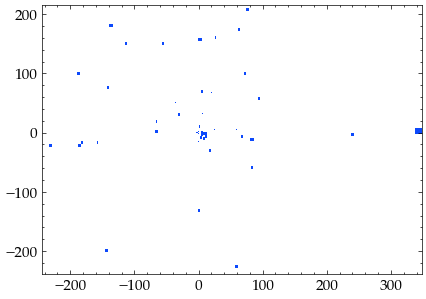

In [28]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from matplotlib import rc
rc('text', usetex=False) 

fig, ax = plt.subplots()

display(len(new_graph.nodes))
for node, data in new_graph.nodes(data=True):
    ax.add_patch(Rectangle((data["x"], data["y"]), data["w"], data["h"]))

x = nx.get_node_attributes(new_graph, "x").values()
w = nx.get_node_attributes(new_graph, "w").values()
y = nx.get_node_attributes(new_graph, "y").values()
h = nx.get_node_attributes(new_graph, "h").values()
plt.xlim(min(x)-max(w), max(x)+max(w))
plt.ylim(min(y)-max(h), max(y)+max(h))

plt.show()